In [16]:
#definição de funções
def tratarValoresMoeda(valor):
    if valor.isnumeric() == True:
        parte1 = valor[:len(valor) - 2];
        parte2 = valor[len(valor) - 2:len(valor)];
        valor = parte1 + '.' + parte2;
        return float(valor);
    else:
        return 0;


def tratarLinha(linha):
    listaCampos = []
    listaCampos.append(linha[2:10]);
    #listaCampos.append(linha[12:24]);
    listaCampos.append(linha[12:24].strip());
    listaCampos.append(linha[27:39]);
    listaCampos.append(linha[56:69]);
    listaCampos.append(linha[69:82]);
    listaCampos.append(linha[82:95]);
    listaCampos.append(linha[95:108]);
    listaCampos.append(tratarValoresMoeda(linha[108:121]));
    return listaCampos;

import numpy as np
def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)- steps - 1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i + steps, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
arquivoOriginal = open('COTAHIST_A2022.TXT',"r");
conteudoArquivo = arquivoOriginal.read();
todasLinhas = conteudoArquivo.split("\n");
quantidadeLinhas = len(todasLinhas);
dados = [];

for indice, linha  in enumerate(todasLinhas):
    if indice > 0 and indice < (quantidadeLinhas - 2):
        # if indice == 10000:
        #     break;
        dados.append(tratarLinha(linha));


In [18]:
import pandas as pd
df = pd.DataFrame();

df = pd.DataFrame(dados, columns=[
    "data_pregao", 
    "cod_neg",
    "nomres",
    "preco_abertura",
    "preco_maximo",
    "preco_minimo",
    "preco_medio",
    "preco_ultimo"]);
pd.to_datetime(df["data_pregao"], format='%Y-%m-%d')
#print(df)
df_acao_petro =  df[df["cod_neg"] == 'PETR4']
df_acao_petro = df_acao_petro[['data_pregao', 'preco_ultimo']]
df_acao_petro = df_acao_petro.sort_values(by='data_pregao')
df_acao_petro = df_acao_petro.set_index(pd.DatetimeIndex(df_acao_petro['data_pregao'].values))
df_acao_petro.drop('data_pregao', axis=1, inplace=True)


print(df_acao_petro)
#print(df);


            preco_ultimo
2022-01-03         29.09
2022-01-04         29.20
2022-01-05         28.07
2022-01-06         28.05
2022-01-07         28.18
...                  ...
2022-07-11         28.66
2022-07-12         28.23
2022-07-13         28.25
2022-07-14         27.49
2022-07-15         27.96

[135 rows x 1 columns]


Text(0.5, 0, 'data')

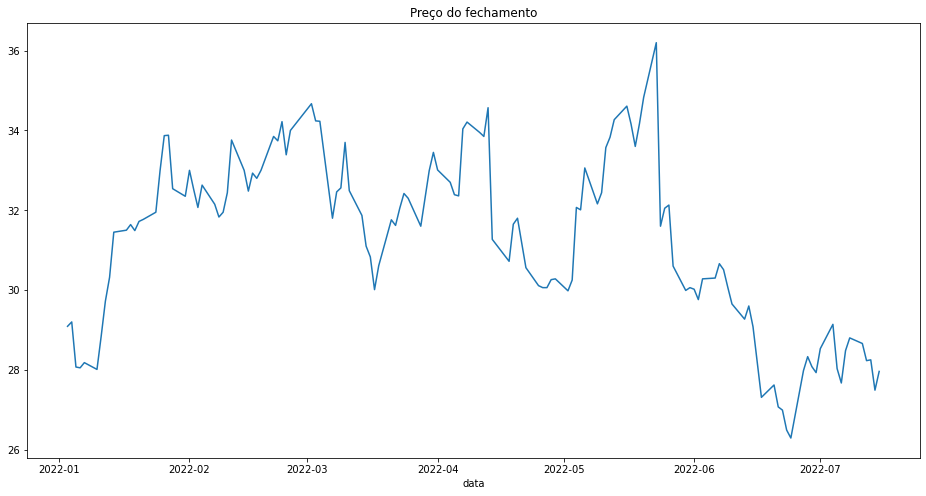

In [19]:

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title('Preço do fechamento')
plt.plot(df_acao_petro['preco_ultimo'])

plt.xlabel('data')

In [20]:
#Normalização de dados
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_acao_petro)


In [21]:
qtd_linhas_petro = len(df_acao_petro)
qtd_linhas_petro_treino = round(.7 * qtd_linhas_petro)

df_treino = df_scaled[:qtd_linhas_petro_treino]
df_teste = df_scaled[qtd_linhas_petro_treino: qtd_linhas_petro_treino+qtd_linhas_petro]

print(len(df_treino), len(df_teste))

94 41


In [22]:
steps = 3
x_treino, y_treino = create_df(df_treino, steps)
x_teste, y_teste = create_df(df_teste, steps)

print(x_treino.shape)
print(y_treino.shape)
print(x_teste.shape)
print(y_teste.shape)

(90, 3)
(90,)
(37, 3)
(37,)


In [23]:
# normalizando para o modelo

x_treino = x_treino.reshape(x_treino.shape[0], x_treino.shape[1], 1)
x_teste = x_teste.reshape(x_teste.shape[0], x_teste.shape[1], 1)


In [24]:

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
modelo = Sequential()
modelo.add(LSTM(35, return_sequences=True, input_shape=(steps,1)))
modelo.add(LSTM(35, return_sequences=True))
modelo.add(LSTM(35))
modelo.add(Dropout(0.2))
modelo.add(Dense(1))

In [25]:
modelo.compile(optimizer='adam', loss='mse')
modelo.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 3, 35)             5180      
                                                                 
 lstm_8 (LSTM)               (None, 3, 35)             9940      
                                                                 
 lstm_9 (LSTM)               (None, 35)                9940      
                                                                 
 dropout_2 (Dropout)         (None, 35)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [26]:

#batch_size - quantidade de info
#verbose - plot
validation = modelo.fit(x_treino, y_treino, validation_data=(x_teste, y_teste), epochs=100, batch_size=15, verbose=2)


Epoch 1/100
6/6 - 5s - loss: 0.6487 - val_loss: 1.5806 - 5s/epoch - 791ms/step
Epoch 2/100
6/6 - 0s - loss: 0.6050 - val_loss: 1.5864 - 41ms/epoch - 7ms/step
Epoch 3/100
6/6 - 0s - loss: 0.5533 - val_loss: 1.5920 - 56ms/epoch - 9ms/step
Epoch 4/100
6/6 - 0s - loss: 0.4823 - val_loss: 1.5928 - 55ms/epoch - 9ms/step
Epoch 5/100
6/6 - 0s - loss: 0.4055 - val_loss: 1.5986 - 57ms/epoch - 9ms/step
Epoch 6/100
6/6 - 0s - loss: 0.3137 - val_loss: 1.5706 - 47ms/epoch - 8ms/step
Epoch 7/100
6/6 - 0s - loss: 0.3107 - val_loss: 1.4827 - 49ms/epoch - 8ms/step
Epoch 8/100
6/6 - 0s - loss: 0.2906 - val_loss: 1.3285 - 47ms/epoch - 8ms/step
Epoch 9/100
6/6 - 0s - loss: 0.2798 - val_loss: 1.2206 - 49ms/epoch - 8ms/step
Epoch 10/100
6/6 - 0s - loss: 0.2643 - val_loss: 1.1108 - 48ms/epoch - 8ms/step
Epoch 11/100
6/6 - 0s - loss: 0.2557 - val_loss: 0.9953 - 48ms/epoch - 8ms/step
Epoch 12/100
6/6 - 0s - loss: 0.2590 - val_loss: 0.8949 - 48ms/epoch - 8ms/step
Epoch 13/100
6/6 - 0s - loss: 0.2466 - val_loss: 

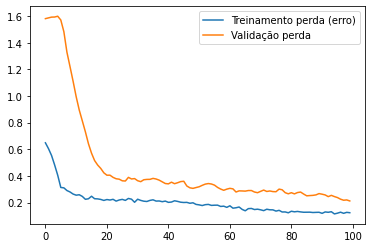

In [31]:
plt.plot(validation.history['loss'], label='Treinamento perda (erro)')
plt.plot(validation.history['val_loss'], label='Validação perda')
plt.legend()

In [30]:
previsao = modelo.predict(x_teste)
previsao = scaler.inverse_transform(previsao)
previsao

2/2 [==============================] - 0s 3ms/step


array([[34.945686],
       [31.44048 ],
       [32.09454 ],
       [32.39157 ],
       [31.117838],
       [30.434196],
       [30.469603],
       [30.48184 ],
       [30.266884],
       [30.593891],
       [30.761692],
       [31.02942 ],
       [30.996214],
       [30.597528],
       [30.17145 ],
       [29.783142],
       [29.924543],
       [29.648535],
       [28.242716],
       [27.757504],
       [27.453625],
       [27.183798],
       [26.825779],
       [26.497166],
       [27.334883],
       [28.348314],
       [28.442654],
       [28.249056],
       [28.582455],
       [29.259123],
       [28.743858],
       [28.074572],
       [28.430172],
       [28.98673 ],
       [29.05318 ],
       [28.700182],
       [28.539831]], dtype=float32)